In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re

# 1. Подготовка данных

In [2]:
andic_df = pd.read_csv('andic_dicts.csv', sep=',')
andic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93875 entries, 0 to 93874
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   lang                            9 non-null      object 
 1   id_word                         93875 non-null  int64  
 2   id_meaning                      93875 non-null  int64  
 3   id                              93875 non-null  int64  
 4   lemma                           93875 non-null  object 
 5   ipa                             93568 non-null  object 
 6   morphology                      52826 non-null  object 
 7   annotator                       93875 non-null  object 
 8   pos                             38710 non-null  object 
 9   concepticon                     584 non-null    object 
 10  meaning_ru                      93822 non-null  object 
 11  definition                      93821 non-null  object 
 12  glottocode                      

In [3]:
Counter(andic_df['glottocode'].to_list())

Counter({'botl1242': 21510,
         'akhv1239': 14020,
         'tind1238': 12726,
         'bagv1239': 12707,
         'cham1309': 10009,
         'andi1255': 8585,
         'ghod1238': 7450,
         'kara1474': 6650,
         'toki1238': 218})

In [4]:
def update_meaning(row):
    if not pd.isnull(row['new_meaning_ru']):
        res = row['new_meaning_ru']
    else:
        res = row['meaning_ru']
        if pd.isnull(res):
            res = 'to_drop'
    drop_list = ['понуд', 'см.', 'см ', 'масд.', 'напр.', 'п.', 'местн.', 'прич.', 'то же']
    for drop in drop_list:
        if drop in res:
            res = 'to_drop'

    if res != 'to_drop':
        if 'имя собств.' not in res:
            res = res.lower()
        res = res.replace('ё', 'е')
        res = res.replace(' ‘', '')
        res = res.replace('  ', ' ')
        res = res.replace('—', '-')
        res = res.replace('!', '')
        res = res.replace('{', '(')
        res = res.replace('}', ')')
        res = res.split(';')[0]
        res = res.split('|||')[0]
        
        res = res.replace('-л.', '-либо')
        if res != 'что-либо' and res != 'кого-либо':
            res = res.replace('кого-либо/что-либо', '')
            res = res.replace('кого- что-либо', '')
            res = res.replace('что-либо', '')
            res = res.replace('кого-либо', '')
        
        res = res.replace('бот.', '')
        res = res.replace('межд.', '')
        res = res.replace('дет.', '')
        res = res.replace('по-детски', '')
        res = res.replace('перен.', '')
        res = res.replace('рел.', '')
        res = res.replace('()', '')
        res = res.replace('звукоподр.', 'звукоподражание')
        res = res.replace('КОЛЛОКАЦИЯ', '(коллокация)')
        res = res.replace('чтобы ни случилось', 'что бы ни случилось')
        res = res.replace('отгонный возглас для', 'возглас, которым отгоняют')
        res = res.replace('отгонный клич для', 'возглас, которым отгоняют')
        res = res.replace('подзывной клич для', 'возглас, которым подзывают')

        sounds = ['звукоподражание', 'возглас', 'выкрик', 'звук']
        for sound in sounds:
            if sound in res:
                res = res.replace(')', '')
                i = res.index(sound)
                res = f'({res[i:]})'
    
        if res[0] == ' ':
            res = res[1::]
        if res[-1] == ' ':
            res = res[:-1]
    
    return res

In [5]:
# to_edit_andic_dicts.csv - база данных, просмотренная вручную
df = pd.read_csv('to_edit_andic_dicts.csv', sep=',')
df['meaning_ru'] = df.apply(update_meaning, axis=1)
df = df[df['meaning_ru'] != 'to_drop']

# визуально было видно повторяющиеся строчки, я решила проверить их наличие по интересующим нас столбцам
df[df.duplicated(subset=['ipa', 'meaning_ru', 'glottocode', 'bor'], keep=False)]

,lang,id_word,id_meaning,id,lemma,ipa,morphology,annotator,pos,concepticon,...,glottocode,reference,comments,source,bor,borrowing_source_language,borrowing_source_transcription,borrowing_modified,borrowing_annotator,language
309,NaN,242,1,310,атIих̄е'тIе,a-t'-i-χː-'e-t'-e,"(-лIи, )",Arseniy Averin,noun,NaN,...,akhv1239,"Magomedova, Abdulayeva 2007",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Akhvakh
310,NaN,243,1,311,атIих̄еᴴ'тIе,a-t'-i-χː-'e-t'-e,"(-лIи, )",Arseniy Averin,noun,NaN,...,akhv1239,"Magomedova, Abdulayeva 2007",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Akhvakh
376,NaN,292,1,377,аᴴ'кьIодада,a-tɬ'-o-d-a-d-a,NaN,Arseniy Averin,pron,NaN,...,akhv1239,"Magomedova, Abdulayeva 2007",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Akhvakh
377,NaN,292,2,378,аᴴ'кьIодада,a-tɬ'-o-d-a-d-a,NaN,Arseniy Averin,noun,NaN,...,akhv1239,"Magomedova, Abdulayeva 2007",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Akhvakh
378,NaN,293,1,379,аᴴ'кьIода,a-tɬ'-o-d-a,NaN,Arseniy Averin,pron,NaN,...,akhv1239,"Magomedova, Abdulayeva 2007",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Akhvakh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93556,NaN,7770,1,93549,ЭРМÁН/ĀЙ,NaN,(-и́йавуб),Zlata Shkutko,NaN,NaN,...,tind1238,Magomedova 2003,NaN,NaN,1.0,rus,NaN,NaN,Dasha Chistyakova,Tindi
93557,NaN,7771,1,93550,ЭРМАНИ́ЙАВУ,NaN,"(-щуб, эрмáнāй)",Zlata Shkutko,NaN,NaN,...,tind1238,Magomedova 2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tindi
93558,NaN,7772,1,93551,ЭРМАНИ́ЙАЙ,NaN,"(-лъ̅илIа, эрмáнāй)",Zlata Shkutko,NaN,NaN,...,tind1238,Magomedova 2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tindi
93561,NaN,7775,1,93554,ЭСÁБ,e-s-'a-b,"(-лIа, -и)",Zlata Shkutko,NaN,NaN,...,tind1238,Magomedova 2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tindi


In [6]:
# удаляем повторяющиеся строки, а также пустые значения 'ipa' и 'meaning_ru'

df = df.drop_duplicates(subset=['ipa', 'meaning_ru', 'glottocode', 'bor'], keep='first')
df = df.dropna(subset=['ipa', 'meaning_ru'], how='any')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81661 entries, 0 to 93824
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   lang                            8 non-null      object 
 1   id_word                         81661 non-null  int64  
 2   id_meaning                      81661 non-null  int64  
 3   id                              81661 non-null  int64  
 4   lemma                           81661 non-null  object 
 5   ipa                             81661 non-null  object 
 6   morphology                      49014 non-null  object 
 7   annotator                       81661 non-null  object 
 8   pos                             33078 non-null  object 
 9   concepticon                     576 non-null    object 
 10  meaning_ru                      81661 non-null  object 
 11  new_meaning_ru                  6200 non-null   object 
 12  definition                      81661

In [7]:
df.to_csv('edited_andic_dicts.csv', index=False)

In [8]:
counter_data = Counter(df['glottocode'].to_list())
counter_data

Counter({'botl1242': 16530,
         'akhv1239': 12788,
         'bagv1239': 10825,
         'tind1238': 10498,
         'cham1309': 9239,
         'andi1255': 8526,
         'ghod1238': 6755,
         'kara1474': 6494,
         'toki1238': 6})

In [17]:
botl1242_value = counter_data['botl1242']
result_dict = {key: value / botl1242_value if key != 'botl1242' else 1 for key, value in counter_data.items()}
result_dict

{'akhv1239': 0.7736237144585602,
 'andi1255': 0.5157894736842106,
 'bagv1239': 0.6548699334543254,
 'botl1242': 1,
 'cham1309': 0.5589231699939504,
 'ghod1238': 0.4086509376890502,
 'kara1474': 0.3928614640048397,
 'tind1238': 0.6350877192982456,
 'toki1238': 0.0003629764065335753}

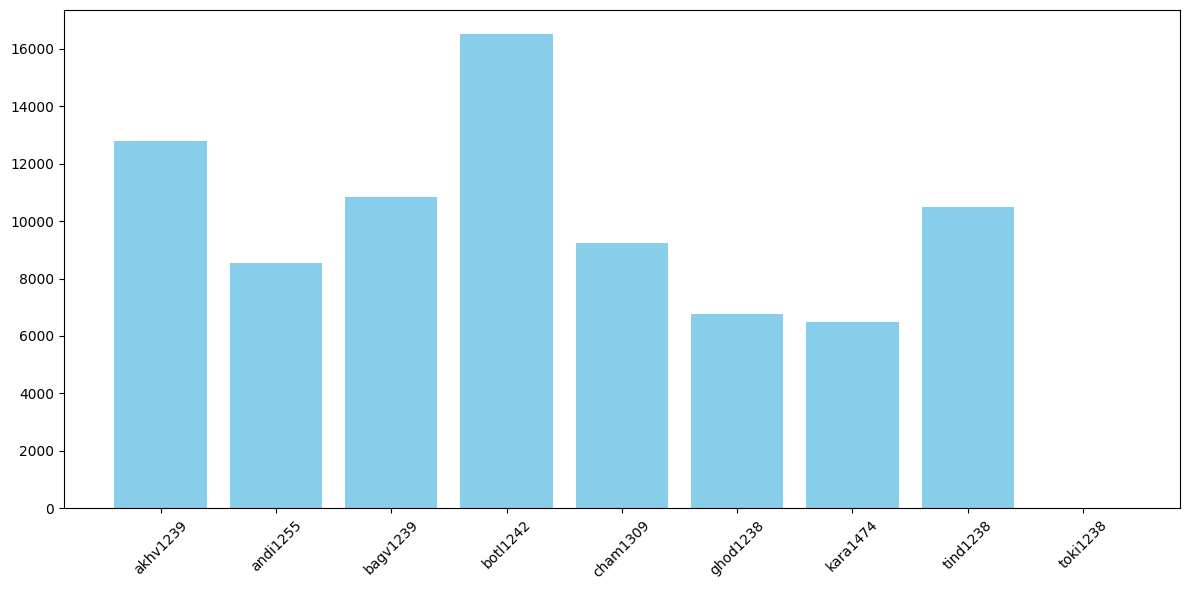

In [9]:
keys = list(counter_data.keys())
values = list(counter_data.values())


plt.figure(figsize=(12, 6))
plt.bar(keys, values, color='skyblue')
plt.xticks(rotation=45)
plt.tight_layout()

In [10]:
# приводим данные к формату необходимому для дальнейшей работы в LexStat

pivot_df = df.pivot_table(index='meaning_ru', columns='glottocode', values='ipa', aggfunc='first')
pivot_df = pivot_df.reset_index()

new_data = []
c = 0

for i in range(len(pivot_df["meaning_ru"])):
    meaning = pivot_df["meaning_ru"][i]
    for language in list(df['glottocode'].unique()):
        ipa = pivot_df[language][i]
        c += 1
        new_data.append({"ID": c, "CONCEPT": meaning, "LANGUAGE": language, "IPA": ipa})

new_df = pd.DataFrame(new_data)

new_df['IPA'] = new_df['IPA'].apply(lambda x: x.replace('-', '') if isinstance(x, str) else x)
new_df['IPA'] = new_df['IPA'].apply(lambda x: x.replace(' ', '') if isinstance(x, str) else x)

# важно заполнить пустые значения, иначе далее программа не будет работать
new_df['IPA'] = new_df['IPA'].fillna('aaa')

new_df

,ID,CONCEPT,LANGUAGE,IPA
0,1,(в соч. с инф. выражает обязательность действи...,akhv1239,aaa
1,2,(в соч. с инф. выражает обязательность действи...,andi1255,aaa
2,3,(в соч. с инф. выражает обязательность действи...,bagv1239,aaa
3,4,(в соч. с инф. выражает обязательность действи...,botl1242,aaa
4,5,(в соч. с инф. выражает обязательность действи...,cham1309,aaa
...,...,...,...,...
233572,233573,ящур (у животных),cham1309,aaa
233573,233574,ящур (у животных),ghod1238,aaa
233574,233575,ящур (у животных),kara1474,t'aːlahu
233575,233576,ящур (у животных),tind1238,aaa


# 2. Распознавание когнатов

In [11]:
from lingpy import *

new_df.to_csv('4ls.qlc', sep='\t', index=False)
wl = Wordlist('4ls.qlc')

In [12]:
lex = LexStat(('4ls.qlc'))

In [13]:
lex.get_scorer(verbose=True,force=True)

CORRESPONDENCE CALCULATION:   0%|                                                           | 0/40.5 [00:00<?, ?it/s]2024-05-25 14:50:45,134 [INFO] Calculating alignments for pair akhv1239 / akhv1239.
CORRESPONDENCE CALCULATION:   5%|██▌                                                | 2/40.5 [00:01<00:26,  1.43it/s]2024-05-25 14:50:46,531 [INFO] Calculating alignments for pair akhv1239 / andi1255.
CORRESPONDENCE CALCULATION:   7%|███▊                                               | 3/40.5 [00:02<00:28,  1.31it/s]2024-05-25 14:50:47,389 [INFO] Calculating alignments for pair akhv1239 / bagv1239.
CORRESPONDENCE CALCULATION:  10%|█████                                              | 4/40.5 [00:03<00:34,  1.06it/s]2024-05-25 14:50:48,633 [INFO] Calculating alignments for pair akhv1239 / botl1242.
CORRESPONDENCE CALCULATION:  12%|██████▎                                            | 5/40.5 [00:04<00:39,  1.11s/it]2024-05-25 14:50:50,063 [INFO] Calculating alignments for pair akhv1239 / cham1

In [14]:
lex.cluster(method="lexstat", threshold=0.6, ref="cognates")

SEQUENCE CLUSTERING:   0%|                                                         | 1/25953 [00:00<46:34,  9.29it/s]2024-05-25 14:59:50,801 [INFO] Analyzing words for concept <(возглас (петухом)>.
2024-05-25 14:59:50,803 [INFO] Analyzing words for concept <(возглас вызова)>.
2024-05-25 14:59:50,805 [INFO] Analyzing words for concept <(возглас недовольствия и недоумения)>.
2024-05-25 14:59:50,808 [INFO] Analyzing words for concept <(возглас одобрения)>.
2024-05-25 14:59:50,810 [INFO] Analyzing words for concept <(возглас петуха)>.
2024-05-25 14:59:50,813 [INFO] Analyzing words for concept <(возглас поцелуя)>.
2024-05-25 14:59:50,815 [INFO] Analyzing words for concept <(возглас удивления)>.
2024-05-25 14:59:50,817 [INFO] Analyzing words for concept <(возглас)>.
2024-05-25 14:59:50,821 [INFO] Analyzing words for concept <(возглас, который погоняют осла)>.
2024-05-25 14:59:50,823 [INFO] Analyzing words for concept <(возглас, который прогоняют петуха)>.
2024-05-25 14:59:50,826 [INFO] Analy

In [15]:
lex.output('qlc',filename='res_ls',ignore=['scorer'])

2024-05-25 15:01:20,192 [INFO] Data has been written to file <res_ls.qlc>.
